In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from GeneratePlot import generatePlot
import xgboost as xgb
# For reading stock data
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
# For time stamps
from datetime import datetime
pd.set_option('display.max_rows', None)  # 设置显示最大行
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [18]:
# Pull stock price of TESLA in 5 years from Yahoo
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)
df = web.DataReader('AAPL', 'yahoo', start=start, end=end)
df = df.reset_index(level=0)
print(df.head())
print(df.info())

        Date       High        Low       Open      Close       Volume  \
0 2017-05-08  38.424999  37.257500  37.257500  38.252499  195009600.0   
1 2017-05-09  38.720001  38.362499  38.467499  38.497501  156521600.0   
2 2017-05-10  38.485001  38.027500  38.407501  38.314999  103222800.0   
3 2017-05-11  38.517502  38.077499  38.112499  38.487499  109020400.0   
4 2017-05-12  39.105000  38.667500  38.674999  39.025002  130108000.0   

   Adj Close  
0  36.063492  
1  36.294464  
2  36.122410  
3  36.434807  
4  36.943649  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   High       1260 non-null   float64       
 2   Low        1260 non-null   float64       
 3   Open       1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Volume     1260 non-null   floa

In [19]:
df["Date"] = pd.to_datetime(df["Date"])
df["DayOfYear"] = df["Date"].dt.dayofyear
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["weekday"] = df["Date"].dt.weekday
df["week"] = df["Date"].dt.week
# 让close列在最右侧
df = df[['Date', 'High', 'Low', 'Open', 'Volume', 'DayOfYear', 'day',
         'month', 'year', 'weekday', 'week', 'Close']]

/var/folders/9s/tq0k5f4s3kb05qxz5458g0rc0000gn/T/ipykernel_20169/2607244295.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df["Date"].dt.week


In [20]:
print(df.columns)
print(df.head())
# 查看df的长度
print(df.shape)

Index(['Date', 'High', 'Low', 'Open', 'Volume', 'DayOfYear', 'day', 'month',
       'year', 'weekday', 'week', 'Close'],
      dtype='object')
        Date       High        Low       Open       Volume  DayOfYear  day  \
0 2017-05-08  38.424999  37.257500  37.257500  195009600.0        128    8   
1 2017-05-09  38.720001  38.362499  38.467499  156521600.0        129    9   
2 2017-05-10  38.485001  38.027500  38.407501  103222800.0        130   10   
3 2017-05-11  38.517502  38.077499  38.112499  109020400.0        131   11   
4 2017-05-12  39.105000  38.667500  38.674999  130108000.0        132   12   

   month  year  weekday  week      Close  
0      5  2017        0    19  38.252499  
1      5  2017        1    19  38.497501  
2      5  2017        2    19  38.314999  
3      5  2017        3    19  38.487499  
4      5  2017        4    19  39.025002  
(1260, 12)


In [22]:
# generate plots
def generatePlot(train_data):
    plt.subplots(figsize=(30, 25))
    plt.title("heatmap of features")
    sns.heatmap(train_data[::500].corr(), cmap="YlGnBu", annot=True, vmin=-0.1, vmax=0.4, center=0)
    plt.show()

    close_weekday = train_data.groupby("weekday", as_index=False)["Close"].mean()
    sns.lineplot(data=close_weekday, x="weekday", y="Close")
    plt.show()

    close_day = train_data.groupby("day", as_index=False)["Close"].mean()
    sns.lineplot(data=close_day, x="day", y="Close")
    plt.show()

    close_month = train_data.groupby("month", as_index=False)["Close"].mean()
    sns.lineplot(data=close_month, x="month", y="Close")
    plt.show()

    sns.lineplot(data=train_data, x="Date", y="Close" )
    plt.show()

    sns.boxplot(data=train_data, x="weekday", y="Close")
    plt.show()

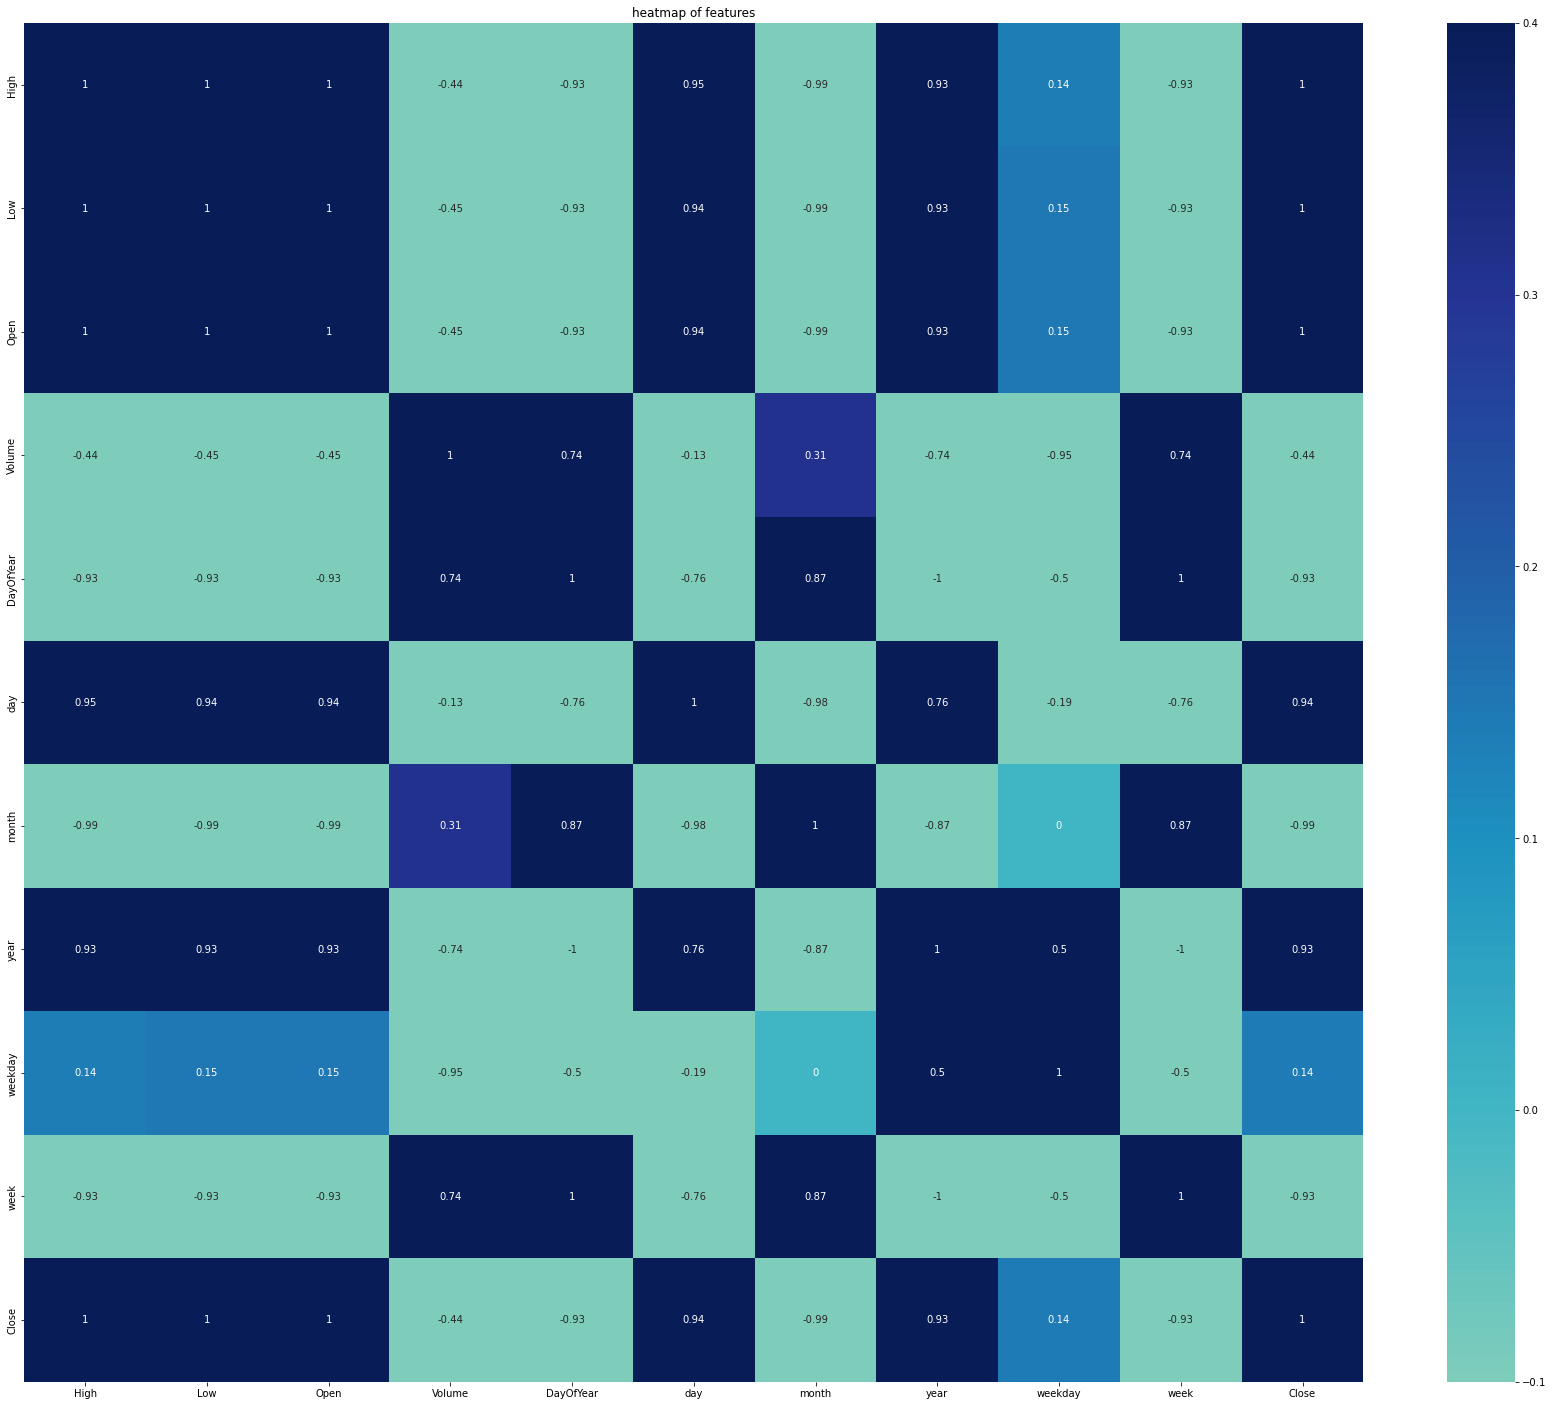

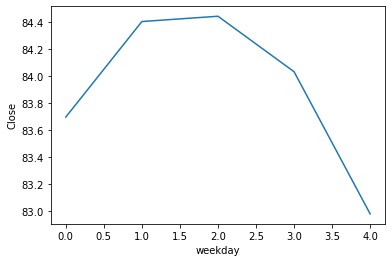

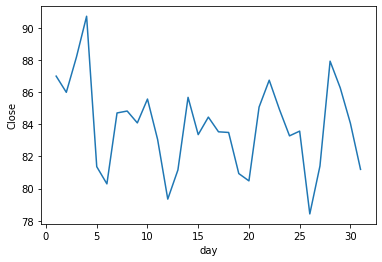

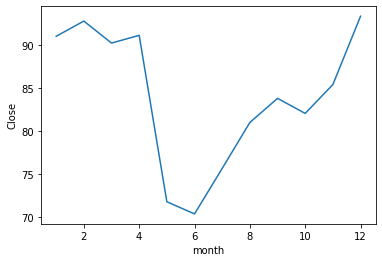

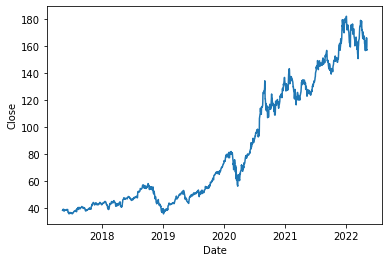

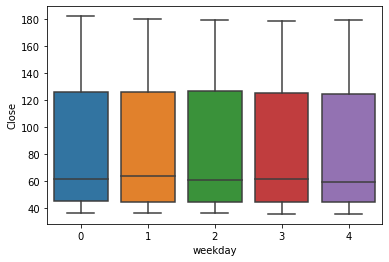

In [23]:
generatePlot(df)
plt.show()

In [24]:
# 将df中Name 改为 数字
df.drop(["Date"], axis=1, inplace=True)
data_np = df.values

# 把前 past_days 天的close price作为特征
data = []
past_days = 60
# 0 - past_days-1都不能用
for i in range(60, df.shape[0]):
    # 拼接data_np的第i行
    # 把前 past_days 天的close price作为特征放到第i天的特征中
    data.append(np.hstack((data_np[i - past_days:i, -1], data_np[i])).tolist())

data = np.array(data)
print(data.shape)

(1200, 71)


In [25]:
split = 0.8
# 用sklearn方法划分训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=1 - split)

2.8448487670787777


/var/folders/9s/tq0k5f4s3kb05qxz5458g0rc0000gn/T/ipykernel_20169/2969273260.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a = a.append(pd.DataFrame({'Close': y_test, 'Type': 'Actual'}))


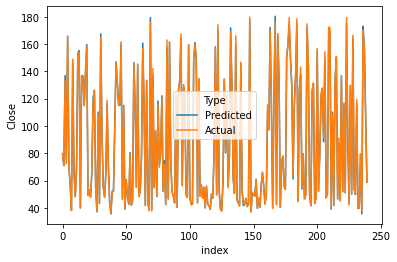

In [27]:
# 定义一个决策树模型
model = DecisionTreeRegressor()
# 训练模型
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
# 计算mse
mse = np.mean((y_hat - y_test) ** 2)
print(mse)

a = pd.DataFrame({'Close': y_hat, 'Type': 'Predicted'})
a = a.append(pd.DataFrame({'Close': y_test, 'Type': 'Actual'}))
a = a.reset_index()

sns.lineplot(data=a, x="index", y="Close", hue="Type")
plt.show()

1.3621604257651938


/var/folders/9s/tq0k5f4s3kb05qxz5458g0rc0000gn/T/ipykernel_20169/2527375807.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a = a.append(pd.DataFrame({'Close': y_test, 'Type': 'Actual'}))


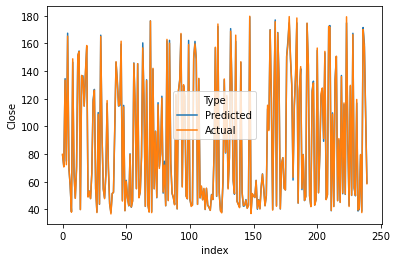

In [28]:
model_random_forest = RandomForestRegressor()
# 训练模型
model_random_forest.fit(X_train, y_train)
y_hat = model_random_forest.predict(X_test)
# 计算mse
mse = np.mean((y_hat - y_test) ** 2)
print(mse)

a = pd.DataFrame({'Close': y_hat, 'Type': 'Predicted'})
a = a.append(pd.DataFrame({'Close': y_test, 'Type': 'Actual'}))
a = a.reset_index()

sns.lineplot(data=a, x="index", y="Close", hue="Type")
plt.show()


In [29]:
def xgboost(x_train_v, y_train_v, x_valid, y_valid, test_data):
    print("Start training xgboost model...")
    y_train_v = np.log(1 + y_train_v)
    y_valid = np.log(1 + y_valid)
    train_matrix = xgb.DMatrix(x_train_v, y_train_v)
    valid_matrix = xgb.DMatrix(x_valid, y_valid)

    param = {'max_depth': 11,
             'eta': 0.02,
             'subsample': 0.75,
             'colsample_bytree': 0.6,
             'objective': 'reg:squarederror', }
    params = list(param.items())
    num_boost_round = 10000
    evals = [(train_matrix, 'train'), (valid_matrix, 'valid')]
    reg = xgb.train(params, train_matrix, num_boost_round, evals,
                    verbose_eval=1, early_stopping_rounds=100)

    y_valid_hat = reg.predict(valid_matrix)
    y_valid_hat = (np.exp(y_valid_hat) - 1)
    mse = np.mean((y_valid_hat - y_test) ** 2)
    print(mse)


#

xgboost(X_train, y_train, X_test, y_test, y_test)

Start training xgboost model...
[0]	train-rmse:3.78967	valid-rmse:3.80880
[1]	train-rmse:3.71431	valid-rmse:3.73327
[2]	train-rmse:3.64056	valid-rmse:3.65922
[3]	train-rmse:3.56821	valid-rmse:3.58671
[4]	train-rmse:3.49724	valid-rmse:3.51557
[5]	train-rmse:3.42770	valid-rmse:3.44589
[6]	train-rmse:3.35947	valid-rmse:3.37747
[7]	train-rmse:3.29277	valid-rmse:3.31052
[8]	train-rmse:3.22736	valid-rmse:3.24482
[9]	train-rmse:3.16319	valid-rmse:3.18040
[10]	train-rmse:3.10030	valid-rmse:3.11727
[11]	train-rmse:3.03865	valid-rmse:3.05539
[12]	train-rmse:2.97827	valid-rmse:2.99470
[13]	train-rmse:2.91900	valid-rmse:2.93514
[14]	train-rmse:2.86090	valid-rmse:2.87692
[15]	train-rmse:2.80398	valid-rmse:2.81981
[16]	train-rmse:2.74821	valid-rmse:2.76387
[17]	train-rmse:2.69354	valid-rmse:2.70903
[18]	train-rmse:2.64002	valid-rmse:2.65531
[19]	train-rmse:2.58761	valid-rmse:2.60277
[20]	train-rmse:2.53617	valid-rmse:2.55119
[21]	train-rmse:2.48571	valid-rmse:2.50061
[22]	train-rmse:2.43641	valid-rm

[188]	train-rmse:0.08819	valid-rmse:0.08983
[189]	train-rmse:0.08645	valid-rmse:0.08808
[190]	train-rmse:0.08475	valid-rmse:0.08638
[191]	train-rmse:0.08309	valid-rmse:0.08472
[192]	train-rmse:0.08146	valid-rmse:0.08309
[193]	train-rmse:0.07986	valid-rmse:0.08149
[194]	train-rmse:0.07830	valid-rmse:0.07992
[195]	train-rmse:0.07676	valid-rmse:0.07839
[196]	train-rmse:0.07526	valid-rmse:0.07687
[197]	train-rmse:0.07379	valid-rmse:0.07540
[198]	train-rmse:0.07235	valid-rmse:0.07396
[199]	train-rmse:0.07095	valid-rmse:0.07256
[200]	train-rmse:0.06955	valid-rmse:0.07117
[201]	train-rmse:0.06819	valid-rmse:0.06981
[202]	train-rmse:0.06686	valid-rmse:0.06849
[203]	train-rmse:0.06556	valid-rmse:0.06718
[204]	train-rmse:0.06428	valid-rmse:0.06590
[205]	train-rmse:0.06302	valid-rmse:0.06465
[206]	train-rmse:0.06180	valid-rmse:0.06342
[207]	train-rmse:0.06059	valid-rmse:0.06220
[208]	train-rmse:0.05941	valid-rmse:0.06103
[209]	train-rmse:0.05824	valid-rmse:0.05987
[210]	train-rmse:0.05711	valid-r

[375]	train-rmse:0.00410	valid-rmse:0.01270
[376]	train-rmse:0.00406	valid-rmse:0.01269
[377]	train-rmse:0.00402	valid-rmse:0.01268
[378]	train-rmse:0.00398	valid-rmse:0.01268
[379]	train-rmse:0.00394	valid-rmse:0.01267
[380]	train-rmse:0.00390	valid-rmse:0.01267
[381]	train-rmse:0.00387	valid-rmse:0.01266
[382]	train-rmse:0.00382	valid-rmse:0.01266
[383]	train-rmse:0.00379	valid-rmse:0.01265
[384]	train-rmse:0.00375	valid-rmse:0.01264
[385]	train-rmse:0.00371	valid-rmse:0.01263
[386]	train-rmse:0.00367	valid-rmse:0.01263
[387]	train-rmse:0.00364	valid-rmse:0.01261
[388]	train-rmse:0.00361	valid-rmse:0.01261
[389]	train-rmse:0.00358	valid-rmse:0.01261
[390]	train-rmse:0.00355	valid-rmse:0.01260
[391]	train-rmse:0.00352	valid-rmse:0.01260
[392]	train-rmse:0.00349	valid-rmse:0.01259
[393]	train-rmse:0.00347	valid-rmse:0.01259
[394]	train-rmse:0.00344	valid-rmse:0.01259
[395]	train-rmse:0.00340	valid-rmse:0.01259
[396]	train-rmse:0.00337	valid-rmse:0.01259
[397]	train-rmse:0.00335	valid-r